In [0]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
import seaborn as sns
import matplotlib.dates as mdates

In [1]:
#Read data
data = pd.read_csv("co2_data.csv")

#Convert the date column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
#Describe data to get some initial statistics
data.describe()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,CO2_PPM
count,3160.000000
mean,355.457699
std,28.282082
min,313.040000
25%,329.902500
50%,352.945000
75%,378.230000
max,415.080000


In [2]:
#Add number of days since measurements started to the data since we use that in
#our model to account for seasonal variation
data['Days since measurement'] = pd.Series(data=[(x-data['Date'][0]).days for x in data['Date']])
data.head()

,Date,CO2_PPM,Days since measurement
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


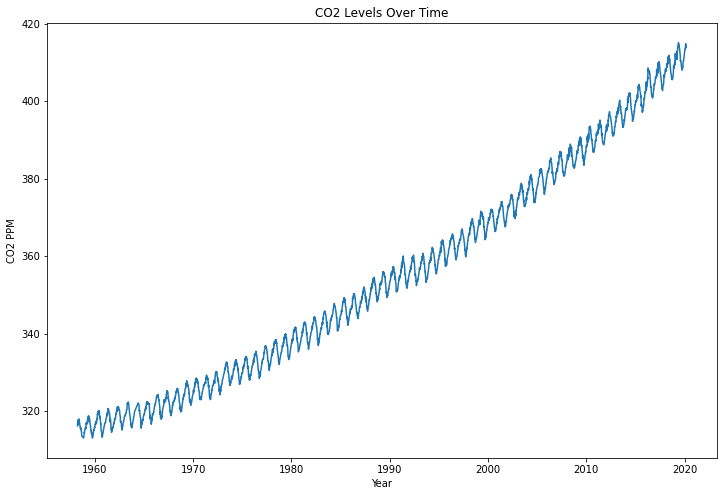

In [3]:
#Plot all data

plt.figure(figsize=(12,8))
plt.plot(data['Date'],data['CO2_PPM'])
plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.show()

In [0]:
#Functions for autocorrelation and pair plots taken from class code

# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

#plot multiple acf plots
def acf_plots(samples,parameters):
    for param in parameters:
        plt.figure(figsize=(10, 3))
        plot_acf(samples[param])
        plt.title('Autocorrelation of '+ str(param) +' samples')
    plt.show()


# Make pair plot of the posteriors over all parameters of the model.
def pair_plots(samples,parameters):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    sns.pairplot(df, size=3.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

In [0]:
#Format data for Stan

stan_data = {
    'N' : len(data),
    'co2_data':data['CO2_PPM'],
    'day':data['Days since measurement']
}

#Example Linear Model

In [0]:
#Stan code for making linear model

linear_model = """

data {  
    int<lower=1> N; // number of observations   
    real<lower=0> co2_data[N] ; //CO2 data 
    int<lower=0> day[N]; // days since measurements began
}

//prior parameters to our model
parameters {  
    
    //Parameters for long term trend
    real<lower=0> c0;
    real<lower=0> c1;
    
    //Parameters for seasonal variation
    real<lower=0> c2;
    real<lower=0> c3;

    //Parameter for gaussian random noise
    real c4; 
    
}

model {

    c0 ~ cauchy(315,10);
    c1 ~ cauchy(0,1);
    
    c2 ~ cauchy(0,1);
    c3 ~ cauchy(0,1);
    
    c4 ~ normal(0,1);
    
    //likelihood function 
    for(i in 1:N) {
        co2_data[i] ~ normal(c0 + c1*day[i] + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 
  }
}

"""

In [7]:
#Compile stan model
stan_model_linear = pystan.StanModel(model_code=linear_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcce04d79d7eb1ded934fb9593dcca9f NOW.


In [8]:
# Fit stan model to the data
stan_linear_results = stan_model_linear.sampling(data=stan_data)
print(stan_linear_results)

Inference for Stan model: anon_model_bcce04d79d7eb1ded934fb9593dcca9f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   305.96  2.3e-3   0.14 305.68 305.87 305.96 306.06 306.24   3698    1.0
c1   4.3e-3  1.7e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3747    1.0
c2     2.72    0.09   0.15   2.44    2.6   2.71   2.84   2.99      3   1.63
c3     2.94    2.08   2.94 2.3e-4 2.3e-3    2.9   5.88   5.93      2 130.19
c4     3.85    0.03   0.06   3.73    3.8   3.85    3.9   3.97      4   1.38
lp__  -5858   25.72  36.41  -5898  -5894  -5862  -5822  -5820      2  24.97

Samples were drawn using NUTS at Fri Apr 24 11:48:45 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#Autocorrelation and pairplots

In [0]:
#get samples
linear_samples = stan_linear_results.extract()

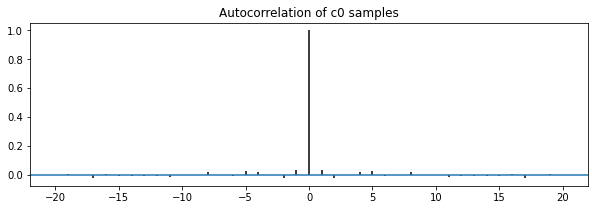

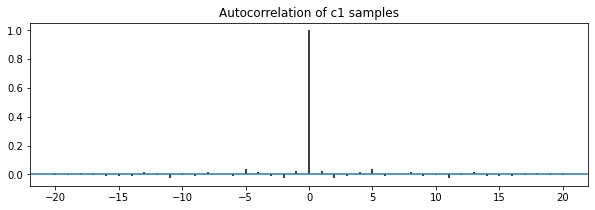

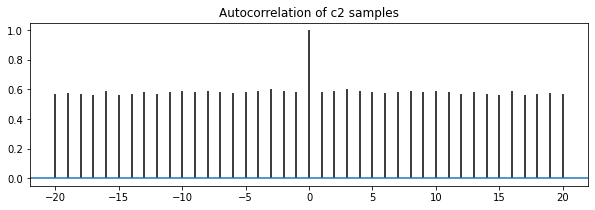

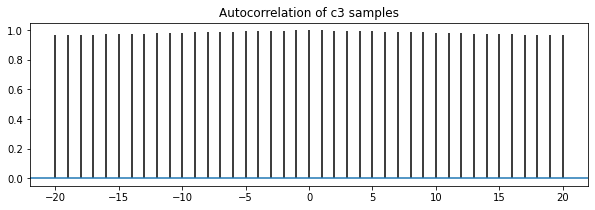

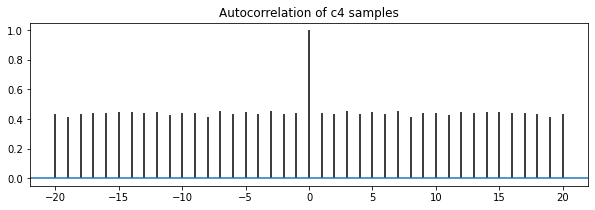

In [10]:
#plot autocorrelation
linear_parameters = ['c0', 'c1', 'c2','c3', 'c4']

acf_plots(linear_samples,linear_parameters)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


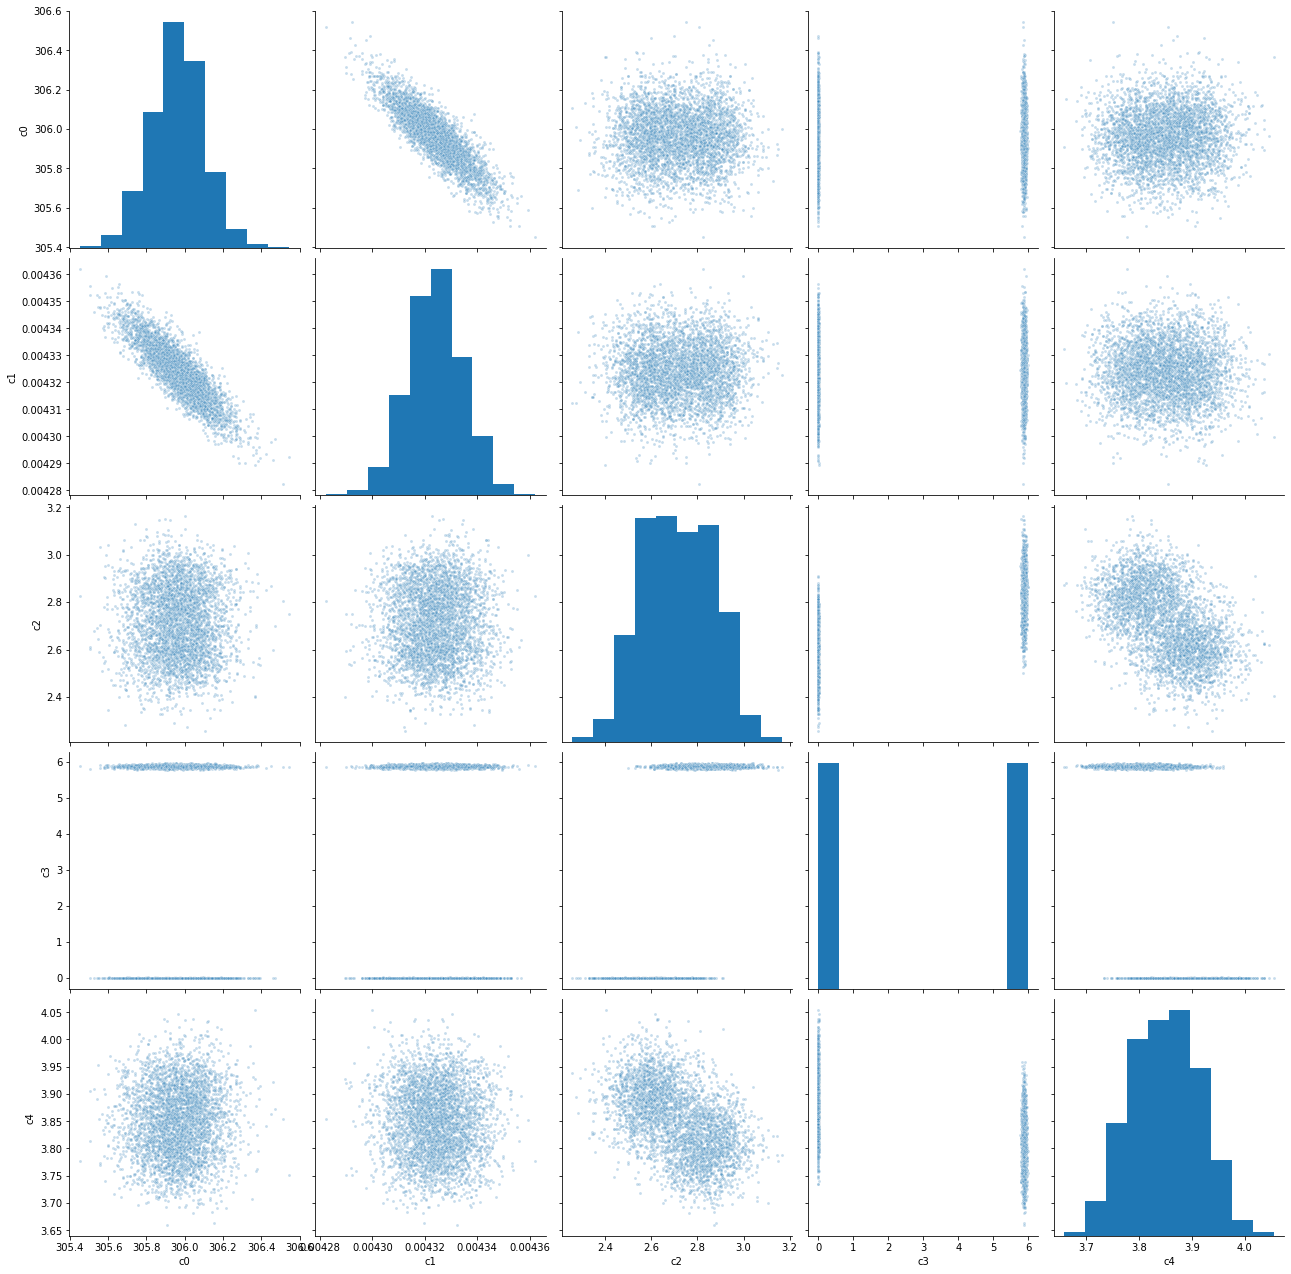

In [11]:
#plot pair plots
pair_plots(linear_samples,linear_parameters)

#Linear Model Modified

In [0]:
#Stan code for making linear model


linear_model_modified = """

data {  
    int<lower=1> N; // number of observations   
    real<lower=0> co2_data[N] ; //CO2 data 
    int<lower=0> day[N]; // days since measurements began
}

//prior parameters to our model
parameters {  
    
    //Parameters for long term trend
    real<lower=0> c0;
    real<lower=0> c1;
    
    //Parameters for seasonal variation
    real<lower=0> c2;
    real<lower=0,upper=3> c3; //bounded at 3 because of two symmetric modes

    //Parameter for gaussian random noise
    real c4; 


    
}

model {

    c0 ~ cauchy(315,10);
    c1 ~ cauchy(0,1);
    
    c2 ~ cauchy(0,1);
    c3 ~ cauchy(0,1);
    
    c4 ~ normal(0,1);


    
    //likelihood function 
    for(i in 1:N) {
        co2_data[i] ~ normal(c0 + c1*day[i] + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 
  }
}

"""



In [13]:
#Compile stan model
stan_model_linear_modified = pystan.StanModel(model_code=linear_model_modified)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6a2594eba84481800899e65932fe9d2 NOW.


In [14]:
# Fit stan model to the data
stan_linear_modified_results = stan_model_linear_modified.sampling(data=stan_data)
print(stan_linear_modified_results)

Inference for Stan model: anon_model_e6a2594eba84481800899e65932fe9d2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   305.97  2.6e-3   0.14 305.69 305.87 305.97 306.06 306.24   2972    1.0
c1   4.3e-3  2.1e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   2718    1.0
c2      2.6  1.7e-3    0.1    2.4   2.53    2.6   2.66    2.8   3324    1.0
c3   3.2e-3  8.3e-5 3.3e-3 9.9e-5 9.2e-4 2.1e-3 4.5e-3   0.01   1540    1.0
c4     3.89  1.1e-3   0.05    3.8   3.86   3.89   3.92   3.99   1940    1.0
lp__  -5895    0.04   1.59  -5899  -5896  -5895  -5894  -5893   1473    1.0

Samples were drawn using NUTS at Fri Apr 24 11:57:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
#Get samples
modified_linear_samples = stan_linear_modified_results.extract()


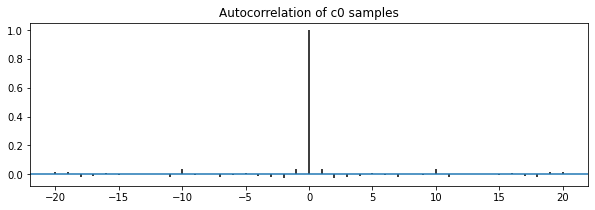

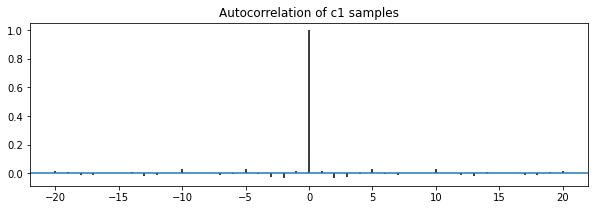

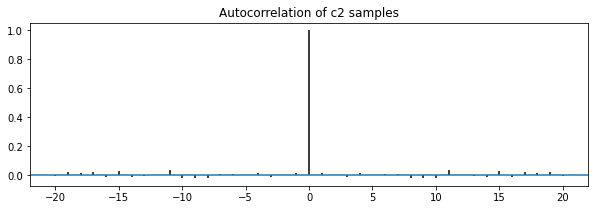

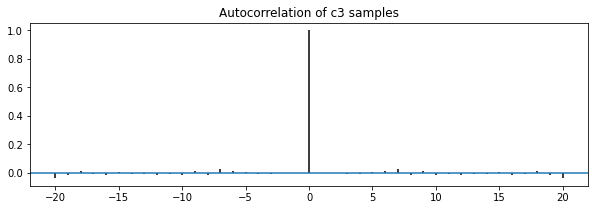

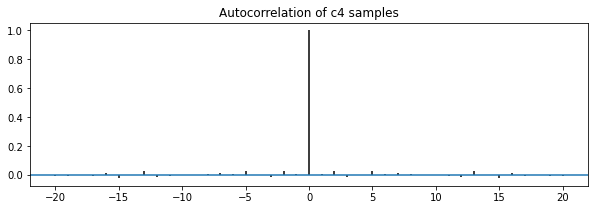

In [16]:
#plot autocorrelation
modified_linear_parameters = ['c0', 'c1', 'c2','c3', 'c4']

acf_plots(modified_linear_samples,modified_linear_parameters)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


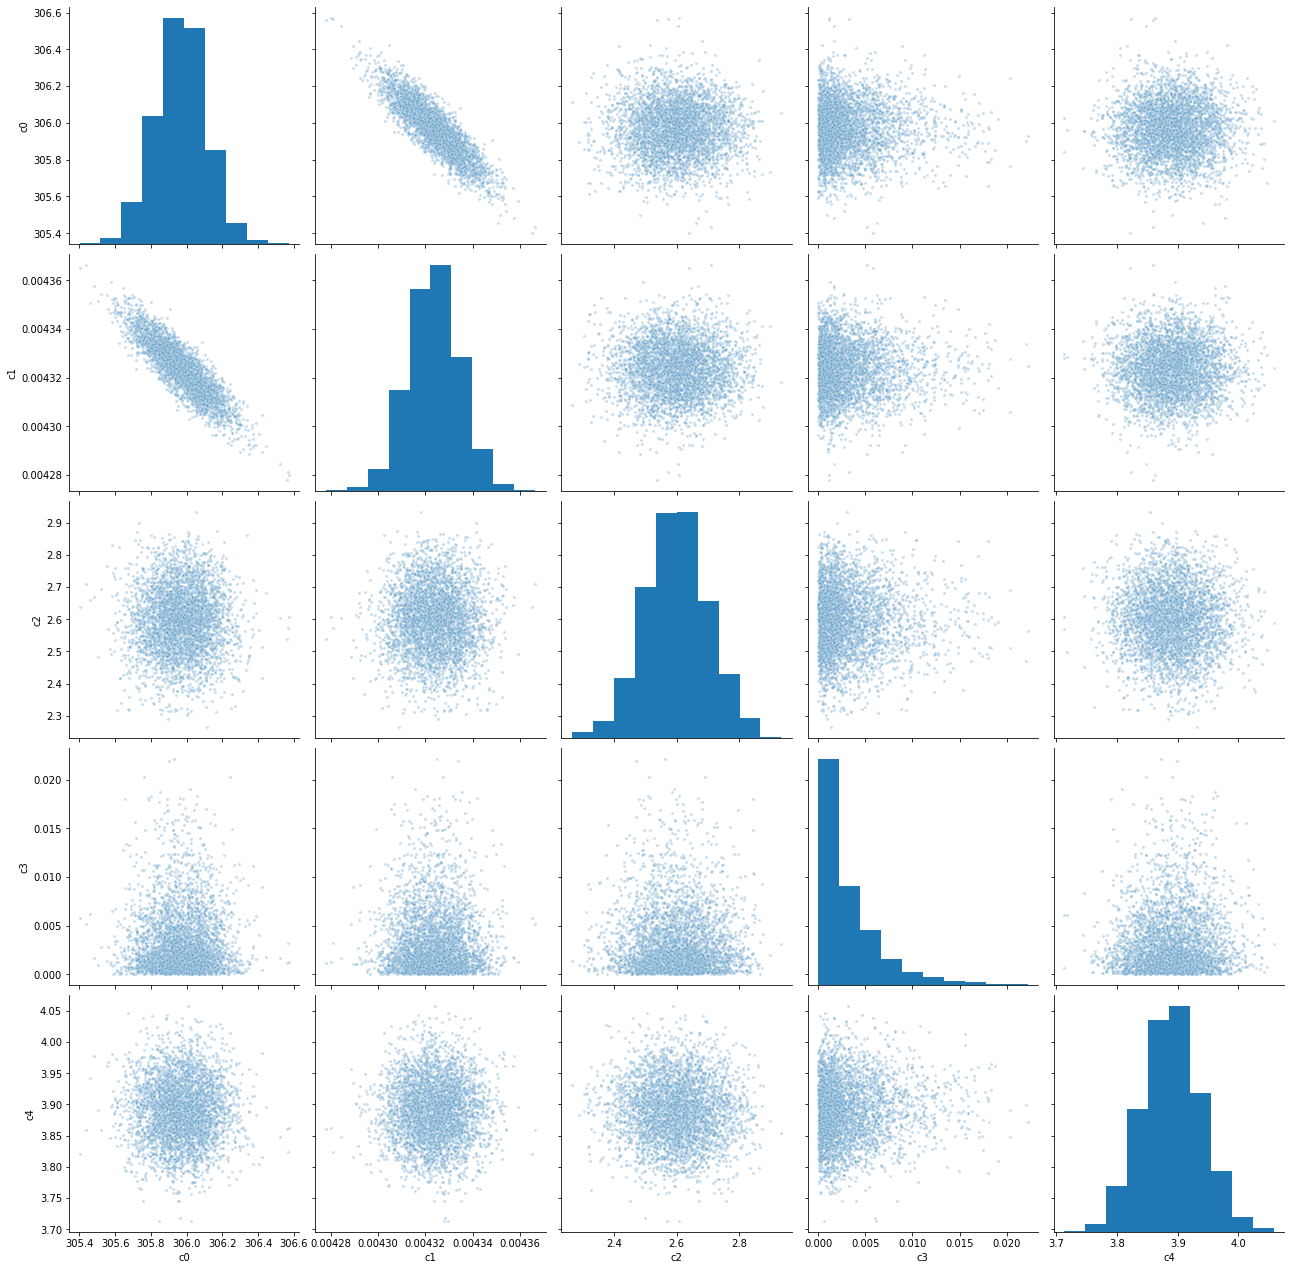

In [17]:
#plot pairplots
pair_plots(modified_linear_samples,modified_linear_parameters)

#Quadratic Model

In [0]:
#Stan code for making quadratic model

quadratic_model = """

data {  
    int<lower=1> N; // number of observations   
    real<lower=0> co2_data[N] ; //CO2 data 
    int<lower=0> day[N]; // days since measurements began
}

//prior parameters to our model
parameters {  
    
    //Parameters for long term trend
    real<lower=0> c0;
    real<lower=0> c1;
    
    //Parameters for seasonal variation
    real<lower=0> c2;
    real<lower=0,upper=3> c3;
    

    //Parameter for gaussian random noise
    real c4; 

    //Parameter for quadratic term
    real<lower=0> c5;

    
}

model {

    c0 ~ cauchy(315,10);
    c1 ~ cauchy(0,1);
    
    c2 ~ cauchy(0,1);
    c3 ~ cauchy(0,1);
    
    c4 ~ normal(0,1);
    c5 ~ normal(0,1);
    
    //likelihood function 
    for(i in 1:N) {
        co2_data[i] ~ normal(c0 + c1*day[i] + c5*(day[i]^2) + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 
  }
}

"""


In [35]:
#Compile stan model
stan_model_quadratic = pystan.StanModel(model_code=quadratic_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_740a574d14dcbf6172e45612e79c0aac NOW.


In [36]:
# Fit stan model to the data
stan_quadratic_results = stan_model_quadratic.sampling(data=stan_data)
print(stan_quadratic_results)

Inference for Stan model: anon_model_740a574d14dcbf6172e45612e79c0aac.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.6  1.9e-3    0.07 314.46 314.55  314.6 314.65 314.74   1404    1.0
c1   2.1e-3  4.3e-7  1.4e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1079    1.0
c2     2.62  6.1e-4    0.03   2.55    2.6   2.62   2.64   2.68   2801    1.0
c3   3.5e-4  6.8e-6  3.4e-4 1.1e-5 1.1e-4 2.5e-4 5.0e-4 1.2e-3   2460    1.0
c4     1.28  3.2e-4    0.02   1.25   1.27   1.28   1.29   1.31   2595    1.0
c5   9.8e-8 1.8e-11 6.0e-10 9.6e-8 9.7e-8 9.8e-8 9.8e-8 9.9e-8   1075    1.0
lp__  -2385    0.05    1.75  -2389  -2386  -2384  -2383  -2382   1350    1.0

Samples were drawn using NUTS at Fri Apr 24 14:23:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [0]:
#get samples
quadratic_samples = stan_quadratic_results.extract()

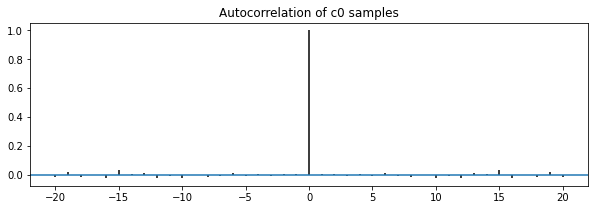

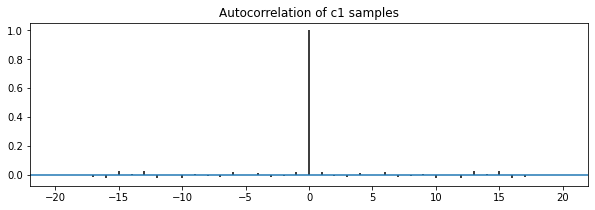

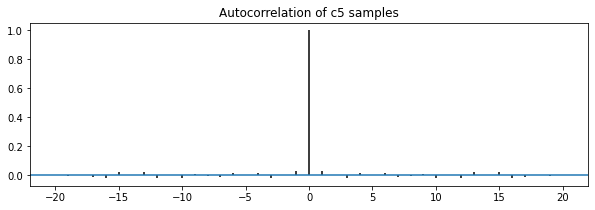

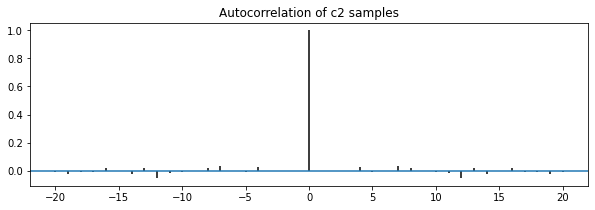

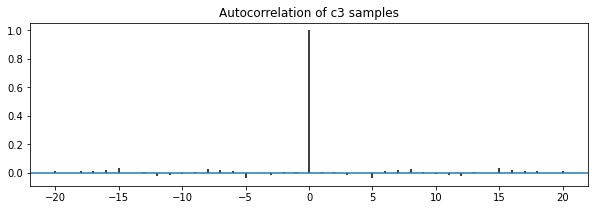

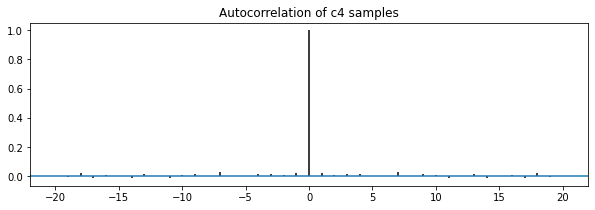

In [22]:
#Plot autocorrelation
quadratic_parameters = ['c0', 'c1', 'c5', 'c2','c3', 'c4']

acf_plots(quadratic_samples,quadratic_parameters)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


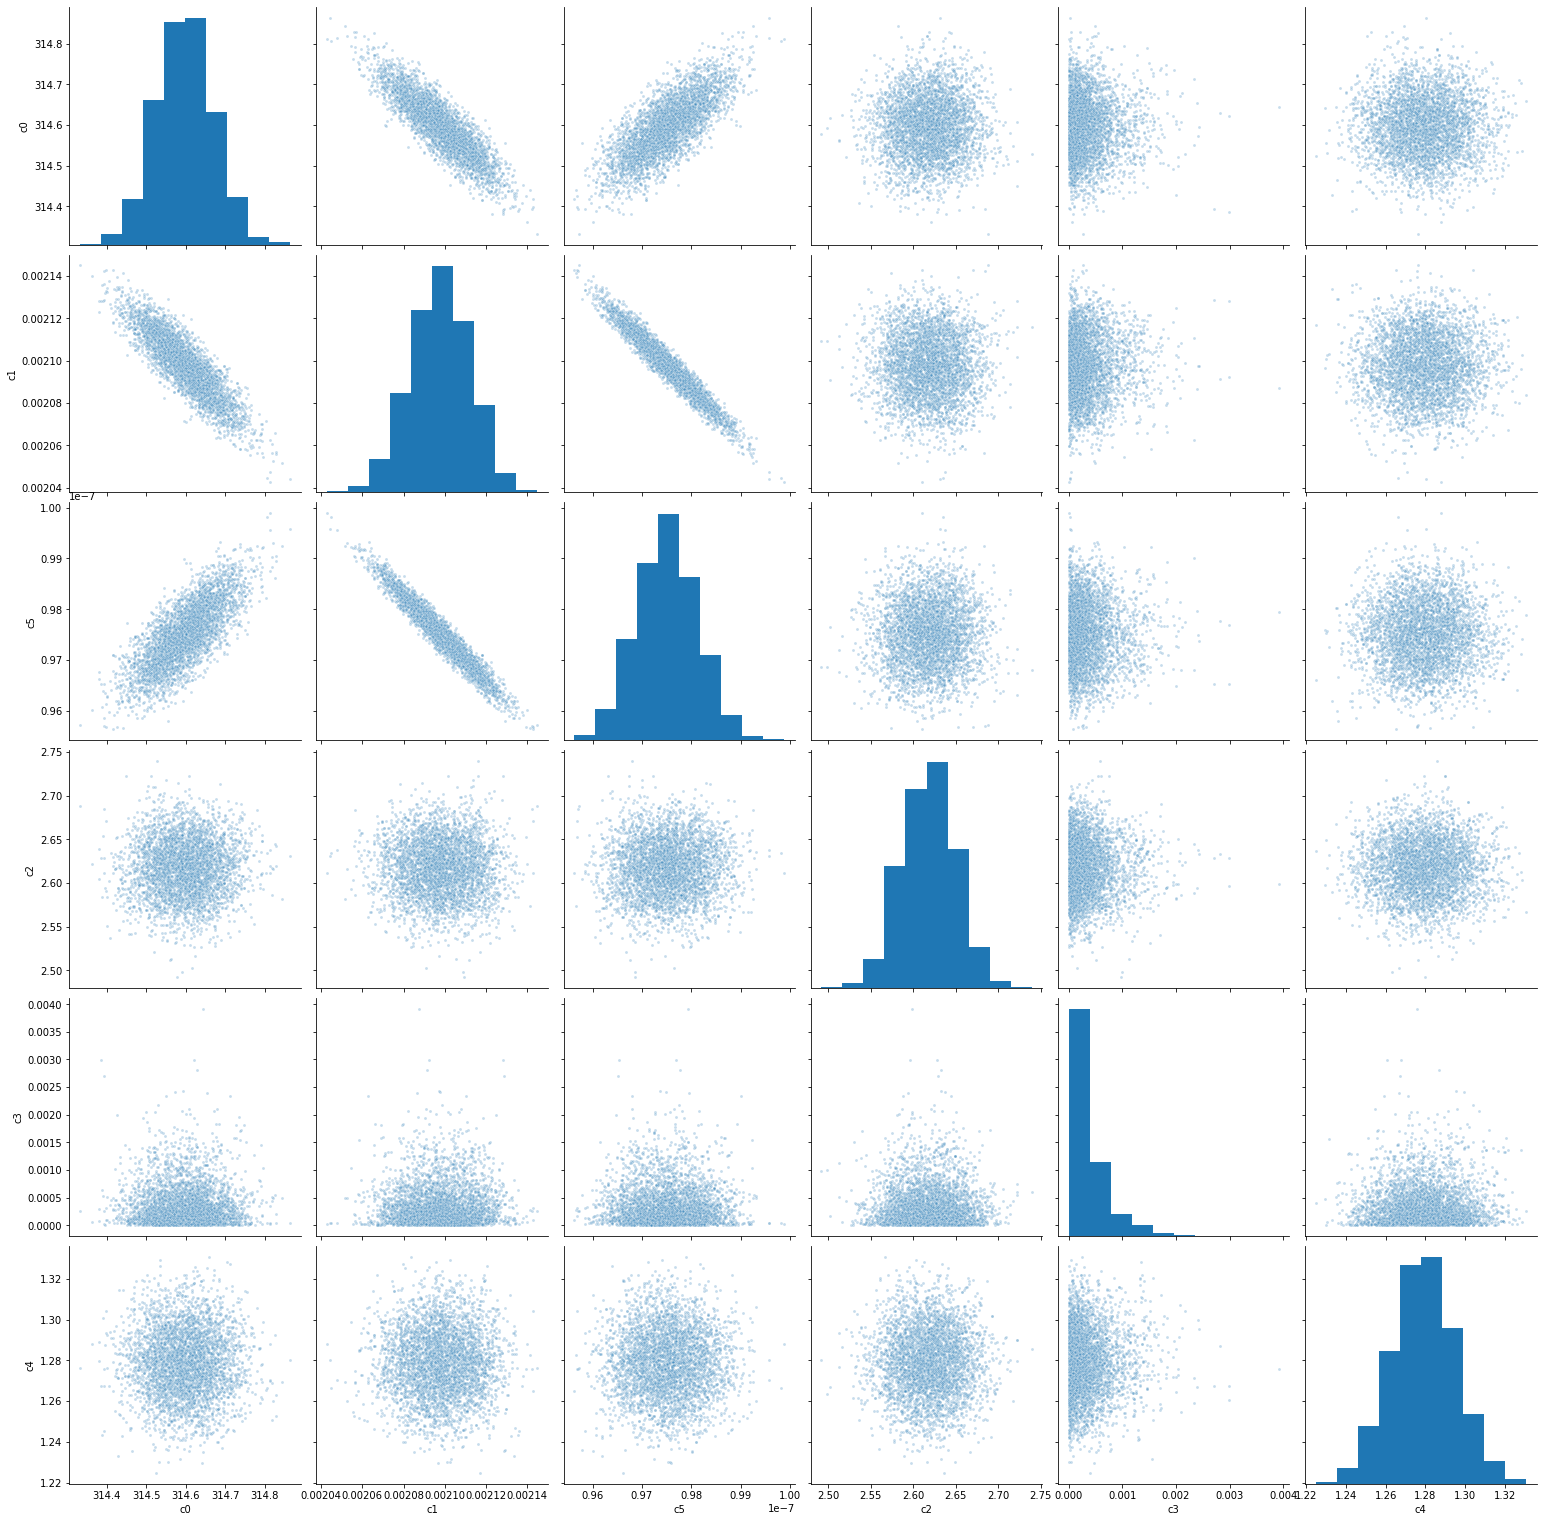

In [23]:
pair_plots(quadratic_samples,quadratic_parameters)

#Plots showing mean for observed data, and mean and 95% CI for future predictions (Modified Linear Model)

In [0]:
from math import cos, pi

#co2_data[i] ~ normal(c0 + c1*day[i] + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 


#Calculate 95% CI of parameters
params_lower = []
params_upper = []
params_mean = []
for i in modified_linear_samples:
  params_lower.append(np.percentile(modified_linear_samples[i],2.5))
  params_upper.append(np.percentile(modified_linear_samples[i],97.5))
  params_mean.append(np.mean(modified_linear_samples[i]))

all_days = np.array(data['Days since measurement'].astype(float))

#Function for predicting co2 level given parameters
def modified_linear_predict(t,c0,c1,c2,c3,c4):
  return sts.norm(c0 + c1*t + c2*cos((2*pi*t)/365.25+c3),c4).rvs()



#Results for all the observed data
all_results_mean = []

for day in all_days:
  all_results_mean.append(modified_linear_predict(day,params_mean[0],params_mean[1],params_mean[2],
                                         params_mean[3],params_mean[4]))

  
#Results for future predictions

#Get the data for future day observations
import datetime
future = datetime.datetime(2060, 1, 1)
future_weeks = round((future - data['Date'][len(data)-1]).days/7)
future_dates = [data['Date'][len(data)-1]+datetime.timedelta(days=(x*7)) for x in range(1,future_weeks)]

#Get future days
future_days = []
for i in range(1,future_weeks):
  future_days.append(data['Days since measurement'][len(data)-1]+(7*i))


#Store results for future
future_results_upper = []
future_results_lower = []
future_results_mean = []
for day in future_days:
  future_results_lower.append(modified_linear_predict(day,params_lower[0],params_lower[1],params_lower[2],
                                         params_lower[3],params_lower[4]))
  future_results_upper.append(modified_linear_predict(day,params_upper[0],params_upper[1],params_upper[2],
                                         params_upper[3],params_upper[4]))
  future_results_mean.append(modified_linear_predict(day,params_mean[0],params_mean[1],params_mean[2],
                                         params_mean[3],params_mean[4]))


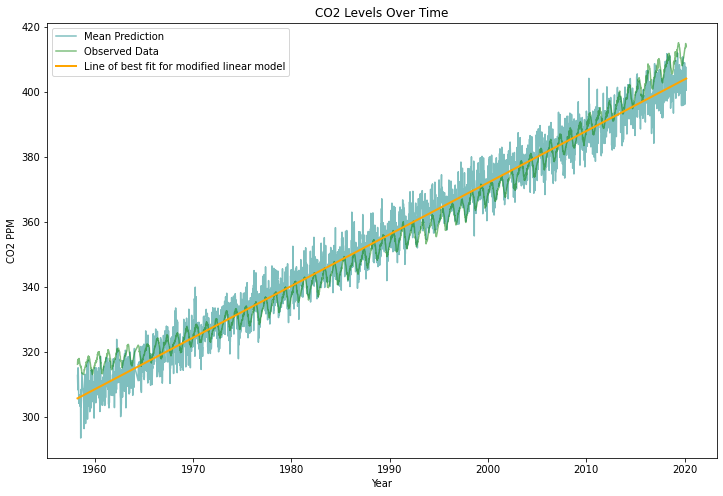

In [25]:

#Plot for all data of modified linear model with mean results

plt.figure(figsize=(12,8))
plt.plot(data['Date'],all_results_mean,label='Mean Prediction',color='teal',alpha=0.5)
plt.plot(data['Date'],data['CO2_PPM'],color='green',label='Observed Data',alpha=0.5)

#Code for line of best fit
x = mdates.date2num(data['Date'])
y = all_results_mean
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),label='Line of best fit for modified linear model',
         color='orange',linewidth=2)


plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

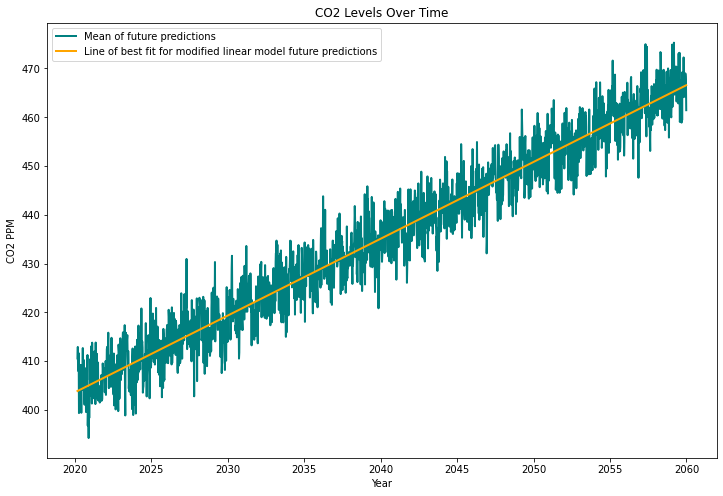

In [26]:
#Plot for future predictions near 2060

plt.figure(figsize=(12,8))
plt.plot(future_dates,future_results_mean,color='teal',label='Mean of future predictions',linewidth=2)

#Code for line of best fit
x1 = mdates.date2num(future_dates)
y1 =  future_results_mean
plt.plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)),label='Line of best fit for modified linear model future predictions',
         color='orange',linewidth=2)

plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

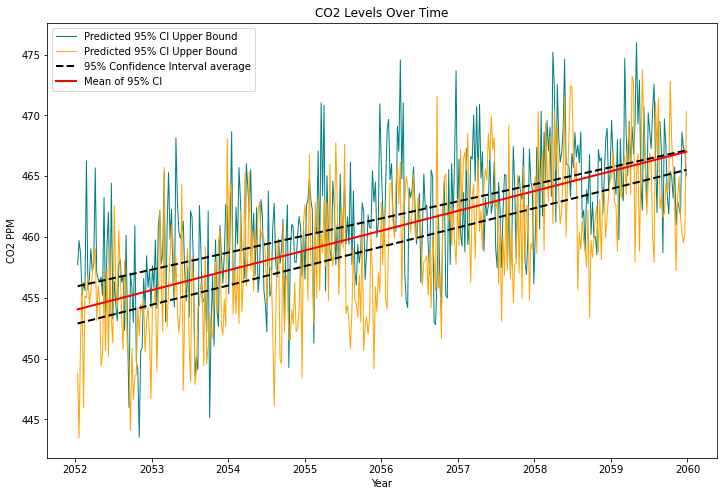

In [27]:
#Zoom in on 2050-ish to 2060 for a clearer view

#Plot for future predictioons

plt.figure(figsize=(12,8))


#Plot raw confidence intervals
plt.plot(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)],future_results_upper[int(len(future_results_upper)*.80) : int(len(future_results_upper) * 1)],
         color='teal',label='Predicted 95% CI Upper Bound',linewidth=1)
plt.plot(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)],future_results_lower[int(len(future_results_lower)*.80) : int(len(future_results_lower) * 1)],
         color='orange',label='Predicted 95% CI Upper Bound',linewidth=1)

#Plot average confidence interval results
x2 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y2 =  future_results_upper[int(len(future_results_upper)*.80) : int(len(future_results_upper) * 1)]
plt.plot(np.unique(x2), np.poly1d(np.polyfit(x2, y2, 1))(np.unique(x2)),'r--',label='95% Confidence Interval average',
         color='black',linewidth=2)


x3 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y3 =  future_results_lower[int(len(future_results_lower)*.80) : int(len(future_results_lower) * 1)]
plt.plot(np.unique(x3), np.poly1d(np.polyfit(x3, y3, 1))(np.unique(x3)),'r--',
         color='black',linewidth=2)

#Plot mean of 95% CI
x4 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y4 =  future_results_mean[int(len(future_results_mean)*.80) : int(len(future_results_mean) * 1)]
plt.plot(np.unique(x4), np.poly1d(np.polyfit(x4, y4, 1))(np.unique(x4)),label='Mean of 95% CI',
         color='red',linewidth=2)


plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

#Plots showing mean for observed data, and mean and 95% CI for future predictions (Quadratic Model)

In [0]:
from math import cos, pi
#Make predictions for the test set

#co2_data[i] ~ normal(c0 + c1*day[i] + c5*(day[i]^2) + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 

all_days = np.array(data['Days since measurement'].astype(float))
#Calculate 95% CI of parameters
quad_params_lower = []
quad_params_upper = []
quad_params_mean = []
for i in quadratic_samples:
  quad_params_lower.append(np.percentile(quadratic_samples[i],2.5))
  quad_params_upper.append(np.percentile(quadratic_samples[i],97.5))
  quad_params_mean.append(np.mean(quadratic_samples[i]))

def quadratic_predict(t,c0,c1,c5,c2,c3,c4):
  return sts.norm(c0 + c1*t + c5*(t**2) + c2*cos((2*pi*t)/365.25+c3),c4).rvs()



#Results for all the observed data
quad_all_results_mean = []

for day in all_days:
  quad_all_results_mean.append(quadratic_predict(day,quad_params_mean[0],quad_params_mean[1],quad_params_mean[5],quad_params_mean[2],
                                         quad_params_mean[3],quad_params_mean[4]))



  
#Results for future predictions

#Get the data for future day observations
import datetime
future = datetime.datetime(2060, 1, 1)
future_weeks = round((future - data['Date'][len(data)-1]).days/7)
future_dates = [data['Date'][len(data)-1]+datetime.timedelta(days=(x*7)) for x in range(1,future_weeks)]

future_days = []
for i in range(1,future_weeks):
  future_days.append(data['Days since measurement'][len(data)-1]+(7*i))

quad_future_results_upper = []
quad_future_results_lower = []
quad_future_results_mean = []
for day in future_days:
  quad_future_results_lower.append(quadratic_predict(day,quad_params_lower[0],quad_params_lower[1],quad_params_lower[5],quad_params_lower[2],
                                         quad_params_lower[3],quad_params_lower[4]))
  quad_future_results_upper.append(quadratic_predict(day,quad_params_upper[0],quad_params_upper[1],quad_params_upper[5],quad_params_upper[2],
                                         quad_params_upper[3],quad_params_upper[4]))
  quad_future_results_mean.append(quadratic_predict(day,quad_params_mean[0],quad_params_mean[1],quad_params_mean[5],quad_params_mean[2],
                                         quad_params_mean[3],quad_params_mean[4]))

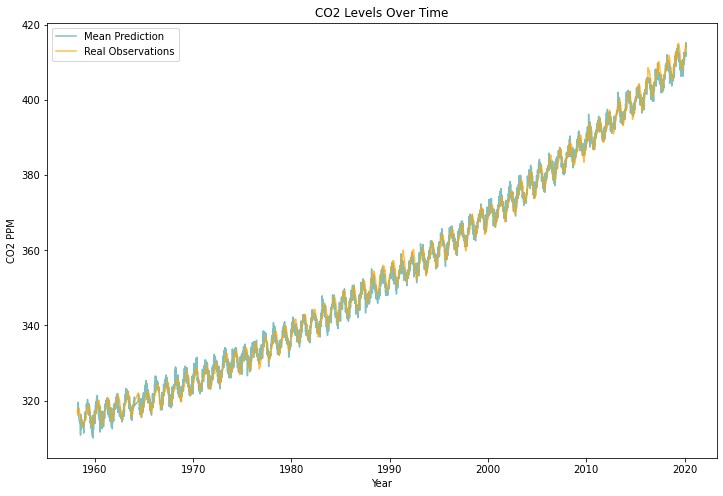

In [29]:
#Plot for observed data vs model predictions

plt.figure(figsize=(12,8))
plt.plot(data['Date'],quad_all_results_mean,label='Mean Prediction',color='teal',alpha=0.5)
plt.plot(data['Date'],data['CO2_PPM'],color='orange',label='Real Observations',alpha=0.7)
plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

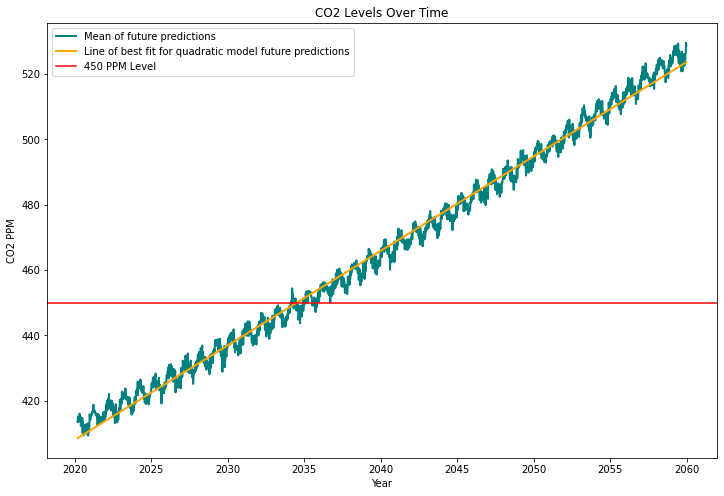

In [30]:
#Plot for future predictions

plt.figure(figsize=(12,8))
plt.plot(future_dates,quad_future_results_mean,color='teal',label='Mean of future predictions',linewidth=2)

#Code for line of best fit
x5 = mdates.date2num(future_dates)
y5 =  quad_future_results_mean
plt.plot(np.unique(x5), np.poly1d(np.polyfit(x5, y5, 1))(np.unique(x5)),label='Line of best fit for quadratic model future predictions',
         color='orange',linewidth=2)

#Plot horizontal line to get an estimate of where we cross the 450PPM level
plt.axhline(y=450, color='r', linestyle='-',label='450 PPM Level')


plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

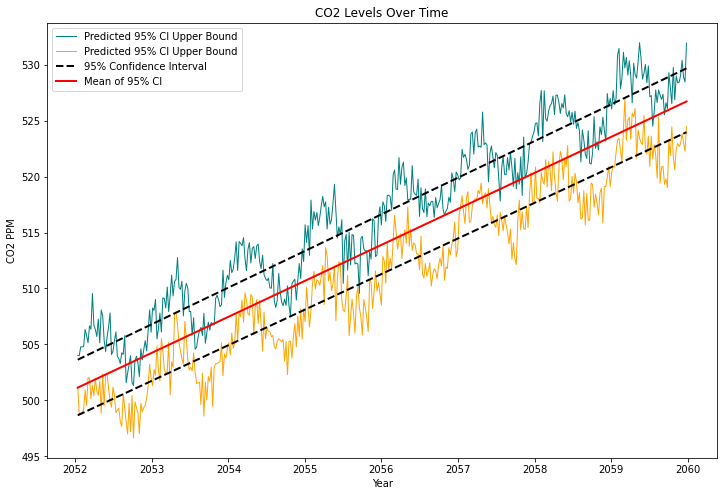

In [31]:
#Zoom in on 2050-ish to 2060 for a clearer view

#Plot for future predictioons

plt.figure(figsize=(12,8))


#Plot raw confidence intervals
plt.plot(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)],quad_future_results_upper[int(len(future_results_upper)*.80) : int(len(future_results_upper) * 1)],
         color='teal',label='Predicted 95% CI Upper Bound',linewidth=1)
plt.plot(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)],quad_future_results_lower[int(len(future_results_lower)*.80) : int(len(future_results_lower) * 1)],
         color='orange',label='Predicted 95% CI Upper Bound',linewidth=1)

#Plot average confidence interval results
x6 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y6 =  quad_future_results_upper[int(len(quad_future_results_upper)*.80) : int(len(quad_future_results_upper) * 1)]
plt.plot(np.unique(x6), np.poly1d(np.polyfit(x6, y6, 1))(np.unique(x6)),'r--',label='95% Confidence Interval',
         color='black',linewidth=2)


x7 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y7 =  quad_future_results_lower[int(len(quad_future_results_lower)*.80) : int(len(quad_future_results_lower) * 1)]
plt.plot(np.unique(x7), np.poly1d(np.polyfit(x7, y7, 1))(np.unique(x7)),'r--',
         color='black',linewidth=2)

#Plot mean of 95% CI
x8 = mdates.date2num(future_dates[int(len(future_dates)*.80):int(len(future_dates)*1)])
y8 =  quad_future_results_mean[int(len(quad_future_results_mean)*.80) : int(len(quad_future_results_mean) * 1)]
plt.plot(np.unique(x8), np.poly1d(np.polyfit(x8, y8, 1))(np.unique(x8)),label='Mean of 95% CI',
         color='red',linewidth=2)


plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.legend()
plt.show()

#Statistical Differences between model and data

In [0]:
#Generate data

#Likelihood function
#co2_data[i] ~ normal(c0 + c1*day[i] + c5*(day[i]^2) + c2*cos((2*pi()*day[i])/365.25 + c3), c4); 
days = np.array(data['Days since measurement'])
generated_data = np.zeros((4000,len(days)))

#Apply likelihood function on each parameter sample for each data point
for i in range(4000):
  for j in range(len(data['Days since measurement'])):
    generated_data[i][j] = sts.norm.rvs(quadratic_samples['c0'][i] + quadratic_samples['c1'][i] * data['Days since measurement'][j] 
                                      + quadratic_samples['c5'][i] *(data['Days since measurement'][j]**2)
                                      + quadratic_samples['c2'][i]*cos((2*pi*data['Days since measurement'][j])/365.25 + quadratic_samples['c3'][i]),
                                      quadratic_samples['c4'][i])
    

In [0]:
#Calculate p-value for test statistics
real_mean = np.mean(data['CO2_PPM'])
real_std = np.std(data['CO2_PPM'])
generated_means = []
generated_std = []
for i in generated_data:
  generated_means.append(np.mean(i))
  generated_std.append(np.std(i))
 
p_val_mean = sum([1 for i in generated_means if i > real_mean])/len(generated_means)
p_val_std = sum([1 for i in generated_std if i > real_std])/len(generated_std)

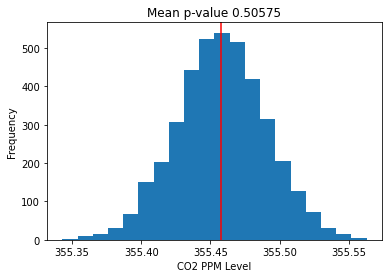

In [39]:
#Plot histograms of mean results

plt.hist(generated_means,bins=20)
plt.axvline(x=real_mean,color='red')
plt.title("Mean p-value " + str(p_val_mean))
plt.xlabel("CO2 PPM Level")
plt.ylabel('Frequency')
plt.show()


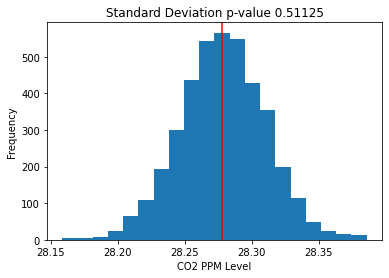

In [38]:
#Plot histogram of standard deviation results
plt.hist(generated_std,bins=20)
plt.axvline(x=real_std,color='red')
plt.title("Standard Deviation p-value " + str(p_val_std))
plt.xlabel("CO2 PPM Level")
plt.ylabel('Frequency')
plt.show()